In [1]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np #for linear algebra

#Libraries for visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Libraries for formattting and handling text 
import string
import re

#Library for nltk
import nltk 
import nltk.corpus
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('stopwords')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer

from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))

#Library for NN
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant


import sklearn
#Library for Splitting Dataset
from sklearn.model_selection import train_test_split
#Library for TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, naive_bayes
#Library for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

import warnings
warnings.filterwarnings("ignore")

import plotly
plotly.offline.init_notebook_mode (connected = True)

!pip install neattext
import neattext as nt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.5 MB/s eta 0:00:00


In [2]:
# only considering train.csv

df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df.head(5)
x = df["text"]
y = df["target"]
print(type(x))

<class 'pandas.core.series.Series'>


# Info and Data Vizualization

In [3]:
df.info()
#filling in NA's for keyword and location
df['keyword'].fillna('no_keyword', inplace=True)
df['location'].fillna('no_location', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Text(0.5, 1.0, 'Total Counts of Real and Fake Disaster Tweets')

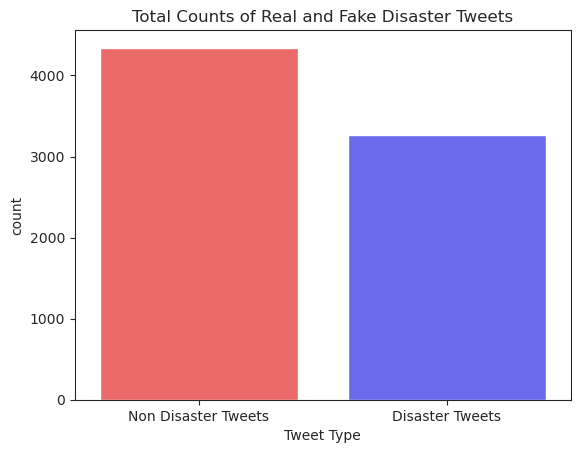

In [4]:
#graphing total counts of fake and real tweets
sns.set_style('ticks')
sns.countplot(x = df.target, data = df, palette = 'seismic_r')
labels = ["Non Disaster Tweets", "Disaster Tweets"]
plt.gca().set_xticklabels(labels)
plt.xlabel("Tweet Type")
plt.gca().set_title('Total Counts of Real and Fake Disaster Tweets')

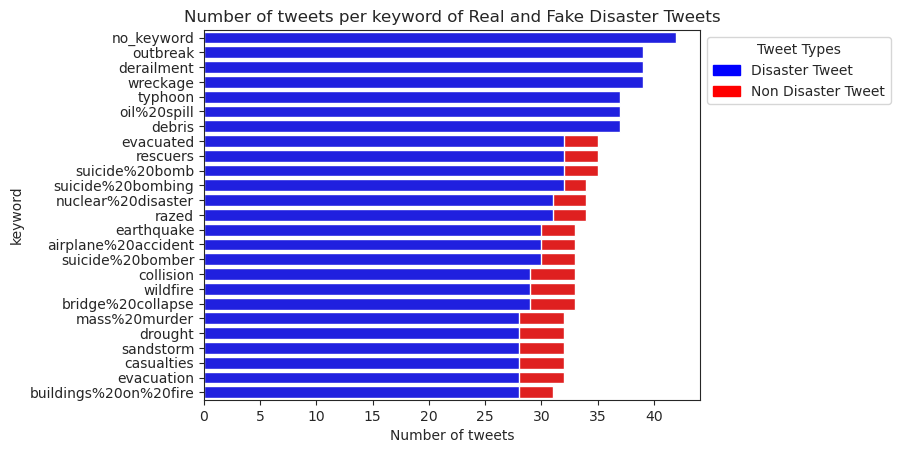

In [5]:
#Number of fake and real tweets according to keyword, TOP 25 only
keyword_fake = df[df['target'] == 0].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]
keyword_real = df[df['target'] == 1].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]

sns.barplot(data=keyword_fake,y=keyword_real.index, x = 'text',color='red',) #number of fake tweets
sns.barplot(data=keyword_real,y=keyword_real.index, x = 'text',color='blue')#number of real tweets
plt.gca().set_xlabel('Number of tweets')
plt.gca().set_title('Number of tweets per keyword of Real and Fake Disaster Tweets')
red = mpatches.Patch(color='red', label='Non Disaster Tweet')
blue = mpatches.Patch(color='blue', label='Disaster Tweet')
plt.legend(loc=2, title='Tweet Types',bbox_to_anchor = (1,1), handles = [blue, red])

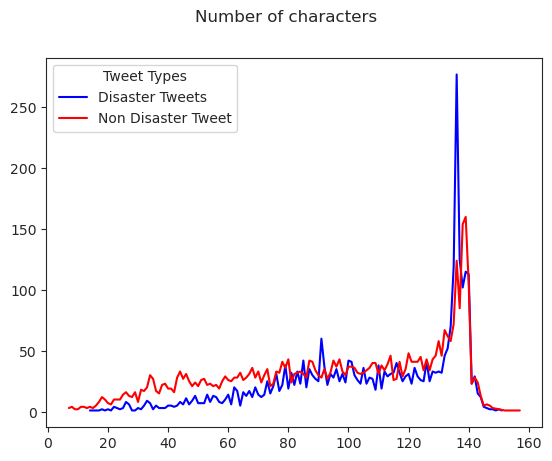

In [6]:
#Graph to display the number of characters for real and fake tweets
real=df[df['target']==1]
fake = df[df['target']==0]

fig, ax1  = plt.subplots()

real_len=real['text'].str.len().value_counts().sort_index()
ax1.plot(real_len.index, real_len.values, label='Disaster Tweets',color='blue')

fake_len=fake['text'].str.len().value_counts().sort_index()
ax1.plot(fake_len.index, fake_len.values, label='Non Disaster Tweet',color='red',)
fig.suptitle('Number of characters')
ax1.legend(title='Tweet Types')
plt.show()

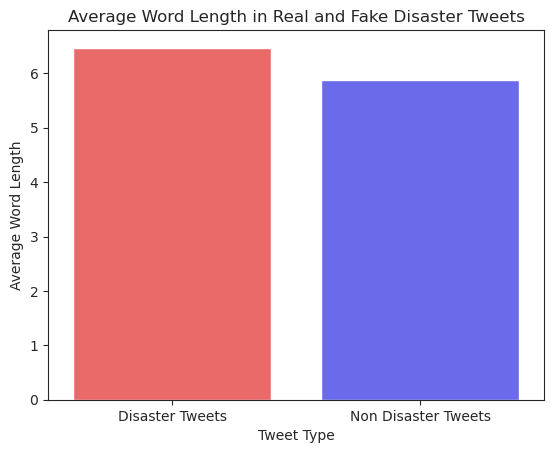

In [7]:
# Calculate the average word length for each set of tweets
real_avg_word_len = real["text"].str.split().apply(lambda x: sum(len(word) for word in x)/len(x)).mean()
fake_avg_word_len = fake["text"].str.split().apply(lambda x: sum(len(word) for word in x)/len(x)).mean()

sns.barplot(x = ["Disaster Tweets", "Non Disaster Tweets"],y = [real_avg_word_len,fake_avg_word_len], palette = 'seismic_r')
plt.title("Average Word Length in Real and Fake Disaster Tweets")
plt.xlabel("Tweet Type")
plt.ylabel("Average Word Length")
plt.show()

# Cleaning Data
---

In [8]:
from sklearn.model_selection import train_test_split
#split the x and y data into training and validation sets, 20% of data allocated to validation set, random state for reproduceability.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape)

(6090,) (1523,)


In [9]:
def clean_data(text):
    #pipeline cleans in order, normalize first, then remove_numbers ETC
    clean_pipeline = nt.TextPipeline(steps=[nt.normalize, nt.remove_numbers, nt.fix_contractions, nt.remove_stopwords, nt.remove_emails, nt.remove_emojis, nt.remove_html_tags, nt.remove_urls, nt.remove_special_characters])
    text = clean_pipeline.transform(text)
 
    #Lemmatization -> reducing a word to its base or dictionary form: "am", "is", "are" -become-> "be"
        # this will normalize the text data and reduce its dimensionality (amount of data)
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([t for t in text.split() if len(t) > 3 ])
    return text

x_train_clean= x_train.apply(clean_data)
print(x_train_clean.head(2))

x_val_clean = x_val.apply(clean_data)
print(x_val_clean.head(2))

4996    courageous honest analysis need atomic bomb ja...
3263    zachzaidman shame golf cart engulfed flame boy...
Name: text, dtype: object
2644                weapon cause unimaginable destruction
2227    famping thing gishwhes soaked deluge going tam...
Name: text, dtype: object


# Sentiment Analysis
---

In [10]:
# Sentiment analysis real tweets
sentiment_real = pd.DataFrame()
sentiment_real['text'] = real['text'].apply(clean_data)

sia = SentimentIntensityAnalyzer()

sentiment_real['sentiment'] = sentiment_real['text'].apply(lambda x: sia.polarity_scores(x))
sentiment_real['max_type'] = sentiment_real['sentiment'].apply(lambda x: max(x, key=x.get))
sent_dict = {'neg': 'negative', 'pos': 'positive', 'neu': 'neutral'}
sentiment_real['max_type'] = sentiment_real['max_type'].replace(sent_dict)
sentiment_real['max_score'] = sentiment_real['sentiment'].apply(lambda x: x[max(x, key=x.get)])
sentiment_real.head()

,text,sentiment,max_type,max_score
0,deed reason earthquake allah forgive,"{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'comp...",neutral,0.656
1,forest fire near ronge sask canada,"{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'comp...",neutral,0.676
2,resident asked shelter place notified officer ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
3,people receive wildfire evacuation order calif...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
4,sent photo ruby alaska smoke wildfire pours sc...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000


In [11]:
# Sentiment analysis fake tweets
sentiment_fake = pd.DataFrame()
sentiment_fake['text'] = fake['text'].apply(clean_data)

sia = SentimentIntensityAnalyzer()

sentiment_fake['sentiment'] = sentiment_fake['text'].apply(lambda x: sia.polarity_scores(x))
sentiment_fake['max_type'] = sentiment_fake['sentiment'].apply(lambda x: max(x, key=x.get))

sentiment_fake['max_type'] = sentiment_fake['max_type'].replace(sent_dict)
sentiment_fake['max_score'] = sentiment_fake['sentiment'].apply(lambda x: x[max(x, key=x.get)])
sentiment_fake.head()

,text,sentiment,max_type,max_score
15,,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",negative,0.000
16,love fruit,"{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp...",positive,0.808
17,summer lovely,"{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'comp...",positive,0.792
18,fast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
19,goooooooaaaaaal,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000


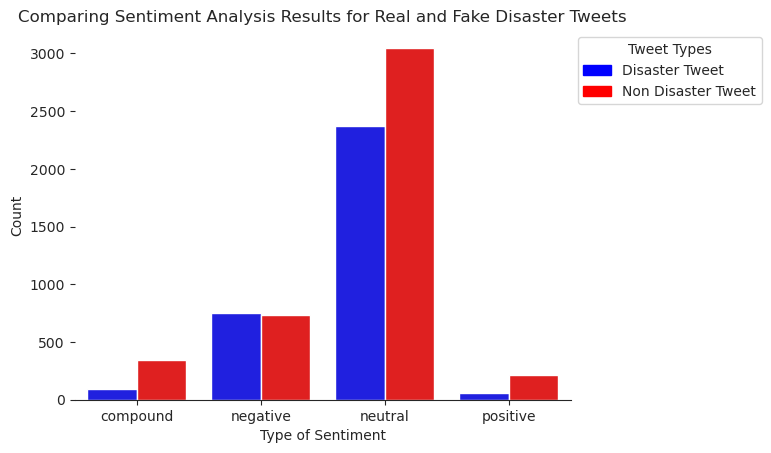

In [12]:
sentiment_counts = pd.DataFrame()
sentiment_counts['Real_Tweets'] = sentiment_real.groupby(['max_type']).size()
sentiment_counts['Fake_Tweets'] = sentiment_fake.groupby(['max_type']).size()


# reset the index to bring "max_type" into a column
sentiment_counts = sentiment_counts.reset_index()

# reshape the data to make it tidy
sentiment_counts = sentiment_counts.melt(id_vars=['max_type'], var_name='tweet_type', value_name='count')

# create the bar plot using Seaborn
sns.barplot(x='max_type', y='count', hue='tweet_type', data=sentiment_counts, palette=["blue", "red"])
sns.despine(left=True)

# set the labels and title
plt.xlabel('Type of Sentiment')
plt.ylabel('Count')
plt.title('Comparing Sentiment Analysis Results for Real and Fake Disaster Tweets')
plt.legend(loc=2, title='Tweet Types',bbox_to_anchor = (1,1), handles = [blue, red])

# show the plot
plt.show()

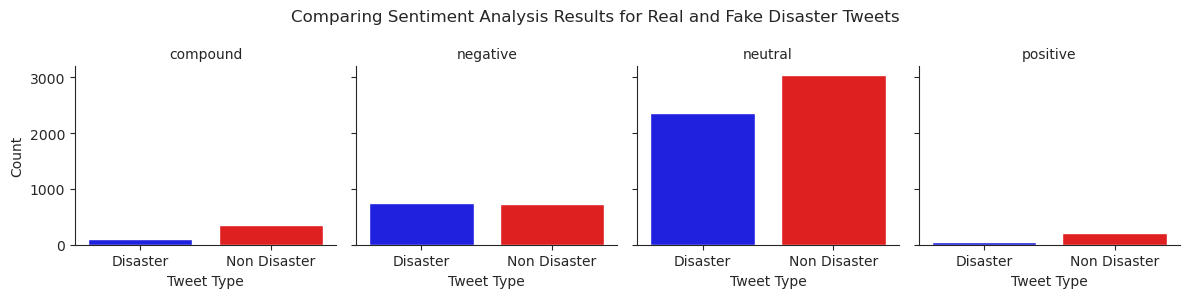

In [13]:
sentiment_counts = pd.DataFrame()
sentiment_counts['Real_Tweets'] = sentiment_real.groupby(['max_type']).size()
sentiment_counts['Fake_Tweets'] = sentiment_fake.groupby(['max_type']).size()

# reshape the DataFrame for plotting
sentiment_counts = sentiment_counts.reset_index()
sentiment_counts = pd.melt(sentiment_counts, id_vars=['max_type'], var_name='tweet_type', value_name='count')

# create the FacetGrid and plot the data
g = sns.FacetGrid(sentiment_counts, col='max_type', margin_titles=True)
g.map(sns.barplot, 'tweet_type', 'count', palette=["blue", "red"])
g.set_axis_labels('Tweet Type', 'Count')
g.set_titles(col_template='{col_name}')
g.set_xticklabels(['Disaster', 'Non Disaster'])
g.fig.suptitle('Comparing Sentiment Analysis Results for Real and Fake Disaster Tweets')
plt.subplots_adjust(top=0.79)
plt.show()

# Vectorization
---

### CountVectorizer & TfidfVectorizer are both used to convert text data into numerical representations that can be used in machine learning models.

* [**CountVectorizer** ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
 - simply counts the occurrence of each word in each document, and represents each document as a vector of word counts.

 

* [**TfidfVectorizer** ](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
 - considers not only the occurrence of each word in each document, but also the frequency of each word across all documents in the dataset. This helps to downweight the importance of common words like "the" and "and" that appear frequently in many documents. The result is a matrix of tf-idf scores, where each document is represented as a vector of tf-idf scores for each word.
 
#### More on [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

In [14]:
tfidf_vect = TfidfVectorizer(max_features=5000)
#constructs a vocabulary of unique words that appear in the x_train data
    #we are training the vectorizer to learn the vocabulary of the text data and to assign an index to each word in the vocabulary.
    #This allows the vectorizer to transform new text documents into numerical feature vectors using the same vocabulary
tfidf_vect.fit(x_train)

#numerical representation of the text data that gives weight to words that are more important
x_train_tfidf = tfidf_vect.transform(x_train)
x_val_tfidf = tfidf_vect.transform(x_val)

In [15]:
count_vect = CountVectorizer()
count_vect.fit(x_train)

x_train_count_vect = count_vect.transform(x_train)
x_val_count_vect = count_vect.transform(x_val)

# Machine Learning Models
### Using different models to test their accuracy.
---

[**DecisionTreeClassifier** ](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- A [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree) is a tree-like model that is built from the data to make decisions. It partitions the data into smaller subsets by recursively dividing it based on the values of the features until the data is split into homogeneous classes. Each internal node in the tree represents a feature, and each branch represents a possible value of that feature. The leaves of the tree represent the predicted class labels. Decision trees are easy to interpret and understand, but they can overfit the data if they are too complex.

[**GradientBoostingClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Gradient boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) is a method of building models by combining multiple weak models to create a stronger model. In the case of the GradientBoostingClassifier, the weak models are decision trees. The algorithm starts by building a decision tree on the data and then iteratively improves the model by adding more decision trees. Each new tree is trained on the errors of the previous trees, and the final prediction is the weighted sum of the predictions of all the trees. Gradient boosting is a powerful method that can achieve high accuracy, but it can be slow and requires careful tuning of hyperparameters.

[**MultinomialNB**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) is a classification algorithm that is based on Bayes' theorem. The MultinomialNB variant assumes that the features are multinomially distributed, meaning that they represent the counts of the number of times each feature occurs in a document. The algorithm estimates the probabilities of each feature occurring in each class and uses these probabilities to predict the class of new documents. Naive Bayes is fast and simple, but it can suffer from the "naive" assumption that the features are independent.

[**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
- [Logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) is a method of estimating the probability of a binary outcome based on the input variables. The algorithm estimates the coefficients of a logistic function that maps the input variables to the probability of the outcome. The logistic function is an S-shaped curve that ranges from 0 to 1, so the output of the model can be interpreted as a probability. Logistic regression is fast and interpretable, but it can suffer from the assumption that the relationship between the input variables and the output is linear.

[**SVC**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [Support vector machines](https://scikit-learn.org/stable/modules/svm.html) (SVMs) are a class of algorithms that are used for classification and regression. The SVC variant is used for classification and works by finding a hyperplane in the feature space that separates the data into different classes. The hyperplane is chosen to maximize the margin, which is the distance between the hyperplane and the closest data points. If the data is not linearly separable, the algorithm can use a kernel function to map the data into a higher-dimensional feature space where it is separable. SVMs are powerful and flexible, but they can be slow and require careful tuning of hyperparameters.

[**SVC(C=10) and SVC(C=0.5)**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- The C parameter in the SVC model controls the trade-off between the smoothness of the decision boundary and the degree to which the model fits the training data. A higher value of C will result in a more complex decision boundary that fits the training data more closely, but may also overfit the data. A lower value of C will result in a smoother decision boundary that generalizes better to new data, but may underfit the training data. By setting C to different values, the SVC model can be tuned to balance between bias and variance.

In [16]:
def model_exec(x_train, y_train, x_val, y_val, models=None):
    if models is None:
        models = [
              DecisionTreeClassifier(),
              GradientBoostingClassifier(),
              sklearn.naive_bayes.MultinomialNB(), 
              sklearn.linear_model.LogisticRegression(),
              sklearn.svm.SVC(),
              sklearn.svm.SVC(C=10),
              sklearn.svm.SVC(C=0.5),
            ]
    else:
        if not isinstance(models, list):
            models = list(models)
            
    accuracy_models = []
    for model in models:
        model.fit(x_train, y_train)
        predictions = model.predict(x_val)
        print("Accuracy Score -> ", model , accuracy_score(predictions, y_val)*100)
        accuracy_models.append((accuracy_score(predictions, y_val)*100, model))
        
    print(accuracy_models)
    return max(accuracy_models)

In [17]:
# using tfidf
max_accuracy, best_model = model_exec(x_train_tfidf, y_train, 
                                      x_val_tfidf, y_val)
print(best_model, max_accuracy)

Accuracy Score ->  DecisionTreeClassifier() 70.19041365725542
Accuracy Score ->  GradientBoostingClassifier() 76.03414313854235
Accuracy Score ->  MultinomialNB() 80.76165462902168
Accuracy Score ->  LogisticRegression() 79.97373604727511
Accuracy Score ->  SVC() 81.22127380170716
Accuracy Score ->  SVC(C=10) 79.97373604727511
Accuracy Score ->  SVC(C=0.5) 80.17071569271175
[(70.19041365725542, DecisionTreeClassifier()), (76.03414313854235, GradientBoostingClassifier()), (80.76165462902168, MultinomialNB()), (79.97373604727511, LogisticRegression()), (81.22127380170716, SVC()), (79.97373604727511, SVC(C=10)), (80.17071569271175, SVC(C=0.5))]
SVC() 81.22127380170716


In [18]:
# using count_vectorizer
max_accuracy, best_model = model_exec(x_train_count_vect, y_train, 
                                      x_val_count_vect, y_val)
print(best_model, max_accuracy)

Accuracy Score ->  DecisionTreeClassifier() 73.60472751149048
Accuracy Score ->  GradientBoostingClassifier() 75.90282337491793
Accuracy Score ->  MultinomialNB() 80.10505581089954
Accuracy Score ->  LogisticRegression() 80.9586342744583
Accuracy Score ->  SVC() 81.08995403808274
Accuracy Score ->  SVC(C=10) 80.23637557452396
Accuracy Score ->  SVC(C=0.5) 78.52921864740644
[(73.60472751149048, DecisionTreeClassifier()), (75.90282337491793, GradientBoostingClassifier()), (80.10505581089954, MultinomialNB()), (80.9586342744583, LogisticRegression()), (81.08995403808274, SVC()), (80.23637557452396, SVC(C=10)), (78.52921864740644, SVC(C=0.5))]
SVC() 81.08995403808274


# Deep Learning
---